## Trial-level early stopping in Ax

This tutorial illustrates how to add a trial-level early stopping strategy to an Ax HPO loop. The goal of trial-level early stopping is to monitor the results of expensive evaluations and terminate those that are unlikely to produce promising results, freeing up resources to explore more configurations.

Most of this tutorial is adapted from the [PyTorch Ax Multiobjective NAS Tutorial](https://pytorch.org/tutorials/intermediate/ax_multiobjective_nas_tutorial.html). The training job is different from the original in that we do not optimize `batch_size` or `epochs`. This was done for illustrative purposes, as each validation curve now has the same number of points. The companion training file `mnist_train_nas.py` has also been altered to log to Tensorboard during training.

NOTE: Although the original NAS tutorial is for a multi-objective problem, this tutorial focuses on a single objective (validation accuracy) problem. Early stopping currently does not support \"true\" multi-objective stopping, although one can use [logical compositions of early stopping strategies](https://github.com/facebook/Ax/blob/main/ax/early_stopping/strategies/logical.py) to target multiple objectives separately. Early stopping for the multi-objective case is currently work-in-progress.

In [1]:
import tempfile

from pathlib import Path

import torch

import torchx

from ax.core import Experiment, Objective, ParameterType, RangeParameter, SearchSpace
from ax.core.optimization_config import OptimizationConfig

from ax.early_stopping.strategies import PercentileEarlyStoppingStrategy
from ax.metrics.tensorboard import TensorboardCurveMetric

from ax.modelbridge.dispatch_utils import choose_generation_strategy

from ax.runners.torchx import TorchXRunner

from ax.service.scheduler import Scheduler, SchedulerOptions
from ax.service.utils.report_utils import exp_to_df

from torchx import specs
from torchx.components import utils

from matplotlib import pyplot as plt
%matplotlib inline

## Defining the TorchX App

Our goal is to optimize the PyTorch Lightning training job defined in
[mnist_train_nas.py](https://github.com/pytorch/tutorials/tree/master/intermediate_source/mnist_train_nas.py)_.
To do this using TorchX, we write a helper function that takes in
the values of the architcture and hyperparameters of the training
job and creates a [TorchX AppDef](https://pytorch.org/torchx/latest/basics.html)_
with the appropriate settings.



In [2]:
def trainer(
    log_path: str,
    hidden_size_1: int,
    hidden_size_2: int,
    learning_rate: float,
    dropout: float,
    trial_idx: int = -1,
) -> specs.AppDef:

    # define the log path so we can pass it to the TorchX AppDef
    if trial_idx >= 0:
        log_path = Path(log_path).joinpath(str(trial_idx)).absolute().as_posix()
    
    epochs = 10
    batch_size = 32
    
    return utils.python(
        # command line args to the training script
        "--log_path",
        log_path,
        "--hidden_size_1",
        str(hidden_size_1),
        "--hidden_size_2",
        str(hidden_size_2),
        "--learning_rate",
        str(learning_rate),
        "--epochs",
        str(epochs),
        "--dropout",
        str(dropout),
        "--batch_size",
        str(batch_size),
        # other config options
        name="trainer",
        script="mnist_train_nas.py",
        image=torchx.version.TORCHX_IMAGE,
    )

## Setting up the Runner

Ax’s [Runner](https://ax.dev/api/core.html#ax.core.runner.Runner)
abstraction allows writing interfaces to various backends.
Ax already comes with Runner for TorchX, and so we just need to
configure it. For the purpose of this tutorial we run jobs locally
in a fully asynchronous fashion. In order to launch them on a cluster, you can instead specify a
different TorchX scheduler and adjust the configuration appropriately.
For example, if you have a Kubernetes cluster, you just need to change the
scheduler from ``local_cwd`` to ``kubernetes``).

The training job launched by this runner will log partial results to Tensorboard, which will then be monitored by the early stopping strategy. We will show how this is done using an Ax 
[TensorboardCurveMetric](https://ax.dev/api/metrics.html#module-ax.metrics.tensorboard) below.

In [3]:
# Make a temporary dir to log our results into
log_dir = tempfile.mkdtemp()

ax_runner = TorchXRunner(
    tracker_base="/tmp/",
    component=trainer,
    # NOTE: To launch this job on a cluster instead of locally you can
    # specify a different scheduler and adjust args appropriately.
    scheduler="local_cwd",
    component_const_params={"log_path": log_dir},
    cfg={},
)

## Setting up the SearchSpace

First, we define our search space. Ax supports both range parameters
of type integer and float as well as choice parameters which can have
non-numerical types such as strings.
We will tune the hidden sizes, learning rate, and dropout parameters.

In [4]:
parameters = [
    # NOTE: In a real-world setting, hidden_size_1 and hidden_size_2
    # should probably be powers of 2, but in our simple example this
    # would mean that num_params can't take on that many values, which
    # in turn makes the Pareto frontier look pretty weird.
    RangeParameter(
        name="hidden_size_1",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="hidden_size_2",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="learning_rate",
        lower=1e-4,
        upper=1e-2,
        parameter_type=ParameterType.FLOAT,
        log_scale=True,
    ),
    RangeParameter(
        name="dropout",
        lower=0.0,
        upper=0.5,
        parameter_type=ParameterType.FLOAT,
    ),
]

search_space = SearchSpace(
    parameters=parameters,
    # NOTE: In practice, it may make sense to add a constraint
    # hidden_size_2 <= hidden_size_1
    parameter_constraints=[],
)

## Setting up Metrics

Ax has the concept of a Metric that defines properties of outcomes and how observations are obtained for these outcomes. This allows e.g. encodig how data is fetched from some distributed execution backend and post-processed before being passed as input to Ax.

We will optimize the validation accuracy, which is a `TensorboardCurveMetric` that points to the logging directory assigned above. Note that we have set `is_available_while_running`, allowing for the metric to be queried as the trial progresses. This is critical for the early stopping strategy to monitor partial results.

In [5]:
class MyTensorboardMetric(TensorboardCurveMetric):

    # NOTE: We need to tell the new Tensorboard metric how to get the id /
    # file handle for the tensorboard logs from a trial. In this case
    # our convention is to just save a separate file per trial in
    # the pre-specified log dir.
    @classmethod
    def get_ids_from_trials(cls, trials):
        return {
            trial.index: Path(log_dir).joinpath(str(trial.index)).as_posix()
            for trial in trials
        }

    # This indicates whether the metric is queryable while the trial is
    # still running. This is required for early stopping to monitor the
    # progress of the running trial.ArithmeticError
    @classmethod
    def is_available_while_running(cls):
        return True

In [6]:
val_acc = MyTensorboardMetric(
    name="val_acc",
    curve_name="val_acc",
    lower_is_better=False,
)

## Setting up the OptimizationConfig

The `OptimizationConfig` specifies the objective for Ax to optimize.

In [7]:
opt_config = OptimizationConfig(
    objective=Objective(
        metric=val_acc,
        minimize=False,
    )
)

## Defining an Early Stopping Strategy

A `PercentileEarlyStoppingStrategy` is a simple method that stops a trial if its performance falls below a certain percentile of other trials at the same step (e.g., when `percentile_threshold` is 50, at a given point in time, if a trial ranks in the bottom 50% of trials, it is stopped). 
- We make use of `normalize_progressions` which normalizes the progression column (e.g. timestamp, epochs, training data used) to be in [0, 1]. This is useful because one doesn't need to know the maximum progression values of the curve (which might be, e.g., the total number of data points in the training dataset).
- The `min_progression` parameter specifies that trials should only be considered for stopping if the latest progression value is greater than this threshold.
- The `min_curves` parameter specifies the minimum number of completed curves (i.e., fully completed training jobs) before early stopping will be considered. This should be larger than zero if `normalize_progression` is used. In general, we want a few completed curves to have a baseline for comparison.

Note that `PercentileEarlyStoppingStrategy` does not make use of learning curve modeling or prediction. More sophisticated model-based methods will be available in future versions of Ax.

In [8]:
percentile_early_stopping_strategy = PercentileEarlyStoppingStrategy(
    # stop if in bottom 70% of runs at the same progression
    percentile_threshold=70,
    # the trial must have passed `min_progression` steps before early stopping is initiated
    # note that we are using `normalize_progressions`, so this is on a scale of [0, 1]
    min_progression=0.3,
    # there must be `min_curves` completed trials and `min_curves` trials reporting data in
    # order for early stopping to be applicable
    min_curves=5,
    # specify, e.g., [0, 1] if the first two trials should never be stopped
    trial_indices_to_ignore=None,
    # check for new data every 10 seconds
    seconds_between_polls=10,
    normalize_progressions=True,
)

## Creating the Ax Experiment

In Ax, the Experiment object is the object that stores all the information about the problem setup.

In [9]:
experiment = Experiment(
    name="torchx_mnist",
    search_space=search_space,
    optimization_config=opt_config,
    runner=ax_runner,
)

## Choosing the GenerationStrategy

A [GenerationStrategy](https://ax.dev/api/modelbridge.html#ax.modelbridge.generation_strategy.GenerationStrategy)
is the abstract representation of how we would like to perform the
optimization. While this can be customized (if you’d like to do so, see
[this tutorial](https://ax.dev/tutorials/generation_strategy.html)),
in most cases Ax can automatically determine an appropriate strategy
based on the search space, optimization config, and the total number
of trials we want to run.

Typically, Ax chooses to evaluate a number of random configurations
before starting a model-based Bayesian Optimization strategy.

We remark that in Ax, generation strategies and early stopping strategies are separate, a design decision motivated by ease-of-use. However, we should acknowledge that jointly considering generation and stopping using a single strategy would likely be the "proper" formulation.

In [10]:
total_trials = 15  # total evaluation budget

gs = choose_generation_strategy(
    search_space=experiment.search_space,
    optimization_config=experiment.optimization_config,
    num_trials=total_trials,
  )

[INFO 12-29 22:48:03] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.


[INFO 12-29 22:48:03] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=4 num_trials=15 use_batch_trials=False


[INFO 12-29 22:48:03] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5


[INFO 12-29 22:48:03] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5


[INFO 12-29 22:48:03] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to model-fitting.


## Configuring the Scheduler

The `Scheduler` acts as the loop control for the optimization.
It communicates with the backend to launch trials, check their status, retrieve (partial) results, and importantly for this tutorial, calls the early stopping strategy. If the early stopping strategy suggests a trial to be the stopped, the `Scheduler` communicates with the backend to terminate the trial.

The ``Scheduler`` requires the ``Experiment`` and the ``GenerationStrategy``.
A set of options can be passed in via ``SchedulerOptions``. Here, we
configure the number of total evaluations as well as ``max_pending_trials``,
the maximum number of trials that should run concurrently. In our
local setting, this is the number of training jobs running as individual
processes, while in a remote execution setting, this would be the number
of machines you want to use in parallel.


In [11]:
scheduler = Scheduler(
    experiment=experiment,
    generation_strategy=gs,
    options=SchedulerOptions(
        total_trials=total_trials, max_pending_trials=5, early_stopping_strategy=percentile_early_stopping_strategy
    ),
)

[INFO 12-29 22:48:03] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


In [12]:
scheduler.run_all_trials()

/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 12-29 22:48:03] Scheduler: Running trials [0]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 12-29 22:48:04] Scheduler: Running trials [1]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 12-29 22:48:05] Scheduler: Running trials [2]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 12-29 22:48:05] Scheduler: Running trials [3]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 12-29 22:48:05] Scheduler: Running trials [4]...


[WARNING 12-29 22:48:06] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 22:48:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:07] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:48:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:17] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:48:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:27] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:48:37] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:37] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:48:47] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:47] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:48:57] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:48:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:48:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:48:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:48:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:48:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:48:57] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:48:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:07] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:17] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:28] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:38] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:48] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:49:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:49:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:49:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:49:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:49:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:49:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:49:58] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:49:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:08] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:08] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:18] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:18] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:28] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:28] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:38] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:48] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:50:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:50:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:50:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:50:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:50:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:50:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:50:59] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:50:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:09] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:51:09] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:51:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:51:19] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:51:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:29] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:51:29] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:51:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:39] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:51:39] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:51:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:49] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:51:49] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:51:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:51:59] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:51:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:51:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:51:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:51:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:51:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:00] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:52:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:52:10] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:52:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:52:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:52:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:52:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:52:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:10] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:52:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:52:20] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:52:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:52:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:52:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:52:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:52:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:20] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:52:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:52:30] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:52:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:52:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:52:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:52:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:52:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:30] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:52:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:52:40] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:52:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/0. Returning without this metric.


[INFO 12-29 22:52:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:52:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:52:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:52:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:40] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 12-29 22:52:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:52:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:52:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:52:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:52:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:52:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:52:51] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:52:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:01] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:53:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/3. Returning without this metric.


[INFO 12-29 22:53:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:53:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:11] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:53:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/4. Returning without this metric.


[INFO 12-29 22:53:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/1. Returning without this metric.


[INFO 12-29 22:53:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:22] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:32] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:43] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:53:53] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:53:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/2. Returning without this metric.


[INFO 12-29 22:53:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:53:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:14] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:24] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:35] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:46] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:54:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:54:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:54:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:37] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:55:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:55:59] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:55:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:56:09] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:56:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:56:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:56:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:56:20] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:56:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:56:30] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:56:30] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:56:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:56:40] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:56:41] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:56:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:56:51] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:56:51] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:56:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:01] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:12] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:12] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:22] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:33] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:33] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:43] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:44] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:57:54] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:57:54] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:57:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:04] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:15] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:15] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:25] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:36] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:36] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:46] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:58:57] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:58:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:58:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:59:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:59:08] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:59:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:59:18] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:59:18] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:59:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:59:28] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:59:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:59:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:59:39] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:59:39] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:59:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 22:59:49] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 22:59:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 22:59:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:00] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:10] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:31] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:00:52] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:00:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:00:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:13] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:24] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:34] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:45] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:01:55] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:01:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:01:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:06] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:16] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:37] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:02:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:02:58] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:02:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:03:09] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:03:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:03:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:20] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:03:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:03:30] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:30] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:03:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:03:40] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:03:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:03:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:51] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[WARNING 12-29 23:03:51] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:03:51] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:03:51] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:03:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:01] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:12] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:12] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:22] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:33] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:33] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:43] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:44] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:04:54] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:04:54] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:04:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:04] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:15] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:15] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:26] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:36] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:37] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:47] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:05:57] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:05:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:05:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:06:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:06:08] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:06:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:06:18] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:06:18] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:06:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:06:28] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:06:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:06:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:06:39] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:06:39] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:06:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:06:49] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:06:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:06:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:00] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:10] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:31] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:07:53] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:07:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:07:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:13] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:24] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:25] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:35] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:46] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:08:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:08:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:08:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:28] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:49] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:09:59] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:09:59] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:09:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:10:09] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:10:10] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:10:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:10:20] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:10:20] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:10:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:10:30] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:10:31] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:10:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:10:41] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:10:41] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:10:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:10:51] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:10:52] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:10:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:02] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:12] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:13] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:23] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:33] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:34] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:44] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:44] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:11:54] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:11:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:11:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:05] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:15] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:16] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:26] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:36] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:37] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:47] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:12:57] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:12:58] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:12:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:13:08] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:13:08] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:13:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:13:18] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:13:19] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:13:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:13:29] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:13:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:13:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:13:39] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:13:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:13:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:13:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:13:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:13:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:11] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:22] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:32] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:43] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:14:53] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:14:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:14:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:14] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:15] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:25] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:25] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:35] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:36] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:46] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:46] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:15:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:15:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:15:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:16:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:16:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:16:18] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:16:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:28] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:16:28] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:16:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:16:39] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:16:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:49] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:16:49] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:16:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:16:59] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:00] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:17:10] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:10] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 12-29 23:17:20] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:21] Scheduler: Retrieved COMPLETED trials: [3].


[INFO 12-29 23:17:21] Scheduler: Fetching data for trials: [3].


[WARNING 12-29 23:17:21] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:17:21] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:21] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:17:31] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:31] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:17:41] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:42] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:17:52] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:17:52] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:17:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:02] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:03] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:13] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:13] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:23] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:23] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:33] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:34] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:44] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:44] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:18:54] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:18:54] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:18:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:19:04] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:05] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:19:15] Scheduler: Fetching data for trials: [0, 1, 2, 4] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:15] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:19:25] Scheduler: Fetching data for trials: 0 - 2 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:25] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:25] Scheduler: Retrieved COMPLETED trials: [4].


[INFO 12-29 23:19:25] Scheduler: Fetching data for trials: [4].


[WARNING 12-29 23:19:26] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:19:26] Scheduler: Fetching data for trials: 0 - 2 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:26] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:19:36] Scheduler: Fetching data for trials: 0 - 2 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:36] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:19:46] Scheduler: Fetching data for trials: 1 - 2 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:19:46] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:19:46] Scheduler: Retrieved COMPLETED trials: [0].


[INFO 12-29 23:19:46] Scheduler: Fetching data for trials: [0].


[INFO 12-29 23:19:51] Scheduler: Running trials [5]...


[INFO 12-29 23:20:25] Scheduler: Running trials [6]...


[INFO 12-29 23:20:49] Scheduler: Running trials [7]...


[WARNING 12-29 23:20:50] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:20:50] Scheduler: Fetching data for trials: [2, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:20:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:20:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:20:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:20:51] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:20:51] Scheduler: Retrieved COMPLETED trials: [1].


[INFO 12-29 23:20:51] Scheduler: Fetching data for trials: [1].


[WARNING 12-29 23:20:53] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:20:53] Scheduler: Fetching data for trials: [2, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:20:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:20:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:20:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:20:53] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:20:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:21:03] Scheduler: Fetching data for trials: [2, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:03] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:21:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 12-29 23:21:13] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:13] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 12-29 23:21:13] Scheduler: Retrieved COMPLETED trials: [2].


[INFO 12-29 23:21:13] Scheduler: Fetching data for trials: [2].


[WARNING 12-29 23:21:15] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:21:15] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:21:15] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:21:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:21:25] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:21:25] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:21:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:21:35] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:21:35] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:21:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:21:45] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:21:45] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:21:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:21:55] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:21:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:21:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:21:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:21:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:21:55] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:21:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:05] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:05] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:15] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:15] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:25] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:26] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:36] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:36] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:46] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:46] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:22:56] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:22:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:22:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:22:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:22:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:22:56] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:22:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:06] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:23:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:06] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:23:06] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:16] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:23:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:23:16] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:26] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:23:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:23:26] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:36] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:23:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:37] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:23:37] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:47] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/5. Returning without this metric.


[INFO 12-29 23:23:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-29 23:23:47] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:23:57] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:23:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:23:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:23:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:23:57] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:23:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:07] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/6. Returning without this metric.


[INFO 12-29 23:24:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:24:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:07] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:17] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:24:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:17] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:27] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/7. Returning without this metric.


[INFO 12-29 23:24:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:28] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:38] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:38] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:48] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:48] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:24:58] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:24:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:24:58] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:24:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:08] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:25:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:25:08] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:25:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:19] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:25:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:25:19] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:25:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:29] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:25:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:25:29] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:25:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:39] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:25:39] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:25:39] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:25:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:49] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:25:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 12-29 23:25:49] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:25:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:25:59] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:00] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:26:10] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:10] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:10] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:26:20] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:20] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:26:30] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:30] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:26:40] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:41] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:26:51] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:26:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:26:51] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:26:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:01] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:01] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:11] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:11] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:21] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:22] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:32] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:32] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:42] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:42] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:27:52] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:27:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:27:52] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:27:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:28:02] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9075106978416443) across comparable trials.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.29994666666666664.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Trial 6's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.29994666666666664.


[INFO 12-29 23:28:03] ax.early_stopping.strategies.base: Trial 7's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:28:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:28:13] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9075106978416443) across comparable trials.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.29994666666666664.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Trial 6's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.29994666666666664.


[INFO 12-29 23:28:13] ax.early_stopping.strategies.base: Trial 7's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:28:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:28:23] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.91011643409729) across comparable trials.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Early stopping decision for 6: True. Reason: Trial objective value 0.9098493456840515 is worse than 70.0-th percentile (0.91011643409729) across comparable trials.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.29994666666666664.


[INFO 12-29 23:28:23] ax.early_stopping.strategies.base: Trial 7's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:28:23] Scheduler: Retrieved EARLY_STOPPED trials: [6].


/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a n

/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
[INFO 12-29 23:28:43] Scheduler: Running trials [8]...


[INFO 12-29 23:28:45] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:28:45] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:28:45] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:28:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:28:45] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:28:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:28:55] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:28:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:28:55] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:28:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:05] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:05] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:29:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:15] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:16] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:29:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:26] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:26] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:29:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:36] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:36] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:29:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:46] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9111847877502441 is better than 70.0-th percentile (0.9110512435436249) across comparable trials.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:47] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181747734546661) across comparable trials.


[INFO 12-29 23:29:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:29:57] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:29:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:29:57] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:29:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:07] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:07] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:17] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:18] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:28] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:28] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:38] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:38] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:48] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:49] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:30:59] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:30:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:30:59] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:30:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:31:09] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:31:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:31:09] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:31:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:31:19] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:31:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:31:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:31:20] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:31:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:31:30] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:31:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:31:30] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:31:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:31:40] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:31:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:31:40] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:31:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:31:50] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:31:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9212576150894165 is better than 70.0-th percentile (0.9174493253231049) across comparable trials.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:31:51] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:31:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:32:01] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:32:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9236095547676086 is better than 70.0-th percentile (0.9195588827133179) across comparable trials.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:32:01] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:32:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:32:11] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:32:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9236095547676086 is better than 70.0-th percentile (0.9195588827133179) across comparable trials.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:32:11] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:32:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:32:21] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:32:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:32:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9236095547676086 is better than 70.0-th percentile (0.9195588827133179) across comparable trials.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:32:22] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:32:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:32:32] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:32:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/8. Returning without this metric.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9236095547676086 is better than 70.0-th percentile (0.9195588827133179) across comparable trials.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.49994666666666665.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:32:32] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.940786600112915 is better than 70.0-th percentile (0.9181705951690674) across comparable trials.


[INFO 12-29 23:32:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:32:42] Scheduler: Fetching data for trials: [5, 7, 8] because some metrics on experiment are available while trials are running.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Early stopping decision for 5: True. Reason: Trial objective value 0.9236095547676086 is worse than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:32:42] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:32:42] Scheduler: Retrieved EARLY_STOPPED trials: [5].


[INFO 12-29 23:32:59] Scheduler: Running trials [9]...


[INFO 12-29 23:33:01] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:33:01] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:33:01] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:01] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:33:11] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:11] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:33:21] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:21] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:33:31] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:32] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:33:42] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:42] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:33:52] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:33:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:33:52] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:33:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:02] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:34:03] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:34:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:13] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:34:13] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:34:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:23] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:34:23] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:34:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:33] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.6999466666666667.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:34:34] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.942490816116333 is better than 70.0-th percentile (0.9252145051956177) across comparable trials.


[INFO 12-29 23:34:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:44] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:44] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:34:44] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:34:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:34:54] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:34:54] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:34:54] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:34:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:04] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:04] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:04] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:15] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:15] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:25] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:25] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:35] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:35] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:36] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:36] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:36] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:46] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:46] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:35:56] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:35:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:35:56] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:35:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:06] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:36:06] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:36:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:17] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:36:17] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:36:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:27] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.7999466666666667.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:36:27] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9426562786102295 is better than 70.0-th percentile (0.9270835518836975) across comparable trials.


[INFO 12-29 23:36:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:37] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/9. Returning without this metric.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.8999466666666667.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.886801
1    0.866598
2    0.921354
3    0.824609
4    0.936255
7    0.942032
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:36:37] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9420321583747864 is better than 70.0-th percentile (0.9288041889667511) across comparable trials.


[INFO 12-29 23:36:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:47] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.8999466666666667.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.886801
1    0.866598
2    0.921354
3    0.824609
4    0.936255
7    0.942032
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:36:48] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9420321583747864 is better than 70.0-th percentile (0.9288041889667511) across comparable trials.


[INFO 12-29 23:36:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:36:58] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.8999466666666667.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.886801
1    0.866598
2    0.921354
3    0.824609
4    0.936255
7    0.942032
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:36:58] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.9420321583747864 is better than 70.0-th percentile (0.9288041889667511) across comparable trials.


[INFO 12-29 23:36:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:37:08] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.9999466666666667.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.892081
1    0.851079
2    0.925707
3    0.812367
4    0.937247
7    0.941504
Name: 0.9999466666666667, dtype: float64.


[INFO 12-29 23:37:08] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.941504180431366 is better than 70.0-th percentile (0.9314767122268677) across comparable trials.


[INFO 12-29 23:37:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:37:18] Scheduler: Fetching data for trials: 7 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 1.0.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.base: Last progression of Trial 7 is 1.0.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.892081
1    0.851079
2    0.925707
3    0.812367
4    0.937247
7    0.941504
Name: 1.0, dtype: float64.


[INFO 12-29 23:37:19] ax.early_stopping.strategies.percentile: Early stopping decision for 7: False. Reason: Trial objective value 0.941504180431366 is better than 70.0-th percentile (0.9314767122268677) across comparable trials.


[INFO 12-29 23:37:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:37:29] Scheduler: Fetching data for trials: 8 - 9 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:29] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:29] Scheduler: Retrieved COMPLETED trials: [7].


[INFO 12-29 23:37:29] Scheduler: Fetching data for trials: [7].


[INFO 12-29 23:37:36] Scheduler: Running trials [10]...


[INFO 12-29 23:37:38] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:37:38] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:37:38] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:37:38] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:37:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:37:48] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:37:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:37:49] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:37:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:37:59] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:37:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:37:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:37:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:38:09] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:38:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:38:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:38:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:38:19] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:38:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:38:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:38:19] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:38:19] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:38:20] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:38:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:38:30] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:38:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.887881
1    0.874506
2    0.911646
3    0.798053
4    0.924704
5    0.916537
7    0.940787
8    0.925071
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9250714778900146 is better than 70.0-th percentile (0.9238871812820435) across comparable trials.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:38:30] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:38:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:38:40] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:38:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:38:40] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:38:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:38:50] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:38:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:38:50] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:38:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:00] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:01] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:11] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:11] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:21] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:21] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:31] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:32] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:42] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:42] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:39:52] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:39:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:39:52] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:39:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:02] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:03] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:13] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:13] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:23] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9280984401702881 is better than 70.0-th percentile (0.9274143576622009) across comparable trials.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:33] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:34] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:44] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:44] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:40:54] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:40:54] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/10. Returning without this metric.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:40:54] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 12-29 23:40:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:04] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:05] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:15] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:15] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:25] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:25] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:25] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:26] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:36] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:36] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:46] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:46] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:41:56] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:41:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:41:57] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:41:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:42:07] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:42:07] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:42:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:42:17] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:42:17] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:42:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:42:27] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9328348636627197 is better than 70.0-th percentile (0.9308318316936492) across comparable trials.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:42:28] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:42:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:42:38] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Early stopping decision for 8: True. Reason: Trial objective value 0.9343148469924927 is worse than 70.0-th percentile (0.9343551397323608) across comparable trials.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 12-29 23:42:38] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:42:38] Scheduler: Retrieved EARLY_STOPPED trials: [8].


/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
[INFO 12-29 23:43:02] Scheduler: Running trials [11]...


[INFO 12-29 23:43:03] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:43:03] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:43:03] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:03] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:43:14] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:14] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:14] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:43:24] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:24] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:24] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:43:34] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:34] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:34] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:43:45] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:45] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:43:55] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:43:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:43:55] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:43:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:05] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:05] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:15] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:16] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:26] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:26] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:36] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:36] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:47] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.882518
1    0.858878
2    0.903837
3    0.769057
4    0.920572
5    0.911185
6    0.909849
7    0.938852
8    0.920311
9    0.937397
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9373974800109863 is better than 70.0-th percentile (0.9203891694545746) across comparable trials.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:47] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:44:57] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:44:57] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:44:57] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:44:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:07] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:07] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:18] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:18] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:28] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:28] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:38] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:38] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:38] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:39] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:49] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:49] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:45:59] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:45:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:45:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:45:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:46:09] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:46:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:46:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:46:10] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:46:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:46:20] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:46:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:46:20] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:46:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:46:30] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:46:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:46:30] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:46:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:46:40] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:46:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:46:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.891685
1    0.859349
2    0.913641
3    0.790424
4    0.930041
5    0.921258
7    0.941914
8    0.928098
9    0.941979
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9419786930084229 is better than 70.0-th percentile (0.929264235496521) across comparable trials.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:46:41] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:46:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:46:51] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:46:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:46:51] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:46:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:01] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/11. Returning without this metric.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9361345767974854 is better than 70.0-th percentile (0.9205724596977234) across comparable trials.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:01] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 12-29 23:47:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:11] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:47:12] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:47:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:22] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:47:22] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:47:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:32] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:47:32] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:47:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:42] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:47:43] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:47:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:47:53] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:47:53] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:47:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:03] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:03] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:13] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:14] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:24] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:24] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:34] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:34] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:44] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.889678
1    0.870384
2    0.915508
3    0.783277
4    0.931634
5    0.923610
7    0.942491
8    0.932835
9    0.943657
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9436571002006531 is better than 70.0-th percentile (0.9323546409606933) across comparable trials.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:45] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:48:55] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9368886947631836 is better than 70.0-th percentile (0.9286166429519653) across comparable trials.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 12-29 23:48:55] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:48:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:05] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:05] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:15] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:16] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:26] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:26] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:36] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:37] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:47] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:47] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:49:57] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:49:57] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:49:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:07] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:08] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:18] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:18] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:28] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:28] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:38] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.888259
1    0.854766
2    0.919651
3    0.827619
4    0.934516
7    0.942656
8    0.934315
9    0.944869
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9448685646057129 is better than 70.0-th percentile (0.9344961643218994) across comparable trials.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:39] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:49] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.9999466666666667.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.892081
1    0.851079
2    0.925707
3    0.812367
4    0.937247
7    0.941504
9    0.946438
Name: 0.9999466666666667, dtype: float64.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9464383721351624 is better than 70.0-th percentile (0.9380980849266052) across comparable trials.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:49] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:50:59] Scheduler: Fetching data for trials: 10 - 11 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9408841729164124 is better than 70.0-th percentile (0.9332942545413971) across comparable trials.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 12-29 23:50:59] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:50:59] Scheduler: Retrieved COMPLETED trials: [9].


[INFO 12-29 23:50:59] Scheduler: Fetching data for trials: [9].


[INFO 12-29 23:51:27] Scheduler: Running trials [12]...


[INFO 12-29 23:51:30] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:51:30] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:51:30] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:51:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:51:31] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:51:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:51:41] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:51:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:51:41] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:51:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:51:51] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:51:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:51:51] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:51:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:01] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:02] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:12] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:12] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:22] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:22] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:22] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:32] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:33] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:43] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:43] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:52:53] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:52:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
Name: 0.6999466666666667, dtype: float64.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9396868944168091 is better than 70.0-th percentile (0.9348904728889466) across comparable trials.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9222540259361267 is better than 70.0-th percentile (0.9217495560646057) across comparable trials.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:52:53] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:52:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:03] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:04] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:14] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:14] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:14] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:24] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:24] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:24] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:34] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:34] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:35] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:45] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:45] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:53:55] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:53:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:53:55] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:53:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:54:05] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:54:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:54:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:54:06] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:54:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:54:16] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:54:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:54:16] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:54:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:54:26] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:54:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
Name: 0.8999466666666667, dtype: float64.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9437251091003418 is better than 70.0-th percentile (0.9414544105529785) across comparable trials.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:54:26] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:54:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:54:36] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:54:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.9999466666666667.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.892081
1     0.851079
2     0.925707
3     0.812367
4     0.937247
7     0.941504
9     0.946438
10    0.943620
Name: 0.9999466666666667, dtype: float64.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9436203837394714 is better than 70.0-th percentile (0.9410784184932709) across comparable trials.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:54:37] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:54:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:54:47] Scheduler: Fetching data for trials: 11 - 12 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:54:47] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/12. Returning without this metric.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.49994666666666665.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
Name: 0.49994666666666665, dtype: float64.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9272705912590027 is better than 70.0-th percentile (0.9272705912590027) across comparable trials.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:54:47] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 12-29 23:54:47] Scheduler: Retrieved COMPLETED trials: [10].


[INFO 12-29 23:54:47] Scheduler: Fetching data for trials: [10].


[INFO 12-29 23:55:23] Scheduler: Running trials [13]...


[INFO 12-29 23:55:25] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 12-29 23:55:25] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:55:25] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:55:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:55:26] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:55:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:55:36] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:55:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:55:36] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:55:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:55:46] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:55:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:55:46] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:55:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:55:56] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:55:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:55:57] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:55:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:07] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:07] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:17] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:17] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:27] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:28] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:38] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:38] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:48] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:48] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:56:58] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:56:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:56:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.5999466666666666.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.891685
1     0.859349
2     0.913641
3     0.790424
4     0.930041
5     0.921258
7     0.941914
8     0.928098
9     0.941979
10    0.940884
11    0.931359
Name: 0.5999466666666666, dtype: float64.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.percentile: Early stopping decision for 11: False. Reason: Trial objective value 0.9313589930534363 is better than 70.0-th percentile (0.9313589930534363) across comparable trials.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:56:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:56:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:57:09] Scheduler: Fetching data for trials: 11 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:57:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.7999466666666667.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
Name: 0.7999466666666667, dtype: float64.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.percentile: Early stopping decision for 11: True. Reason: Trial objective value 0.9371220469474792 is worse than 70.0-th percentile (0.9384101510047913) across comparable trials.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:57:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:57:09] Scheduler: Retrieved EARLY_STOPPED trials: [11].


[INFO 12-29 23:57:31] Scheduler: Running trials [14]...


[WARNING 12-29 23:57:31] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-29 23:57:31] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:57:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:57:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:57:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:57:31] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:57:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:57:41] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:57:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:57:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:57:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:57:41] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:57:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:57:51] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:57:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:57:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:57:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:57:51] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:57:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:01] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:02] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:12] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:12] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:22] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:22] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:22] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:22] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:32] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:32] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:42] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:42] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:58:52] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:58:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:58:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:58:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:58:53] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:58:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:03] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:59:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:59:03] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:59:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:13] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:59:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 12-29 23:59:13] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-29 23:59:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:23] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/13. Returning without this metric.


[INFO 12-29 23:59:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-29 23:59:23] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-29 23:59:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:33] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-29 23:59:34] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-29 23:59:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:44] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:44] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-29 23:59:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-29 23:59:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-29 23:59:54] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-29 23:59:54] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-29 23:59:54] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-29 23:59:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:04] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:04] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:05] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:15] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:15] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:25] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:25] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:35] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:36] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:46] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:46] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:00:56] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:00:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:00:56] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:00:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:06] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:07] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:01:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:17] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9391956329345703 is better than 70.0-th percentile (0.9278062462806701) across comparable trials.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:17] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:01:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:27] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:27] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:01:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:37] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:37] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpk7ogo2qd/14. Returning without this metric.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:38] ax.early_stopping.strategies.base: There is not yet any data associated with trial 14. Not early stopping this trial.


[INFO 12-30 00:01:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:48] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:01:48] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:01:58] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:01:58] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:01:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:02:08] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:02:09] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:02:19] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:02:19] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:02:29] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:02:29] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:02:39] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:02:40] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:02:50] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:02:50] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:02:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:00] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:03:00] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:01] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:01] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:01] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:01] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:03:01] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:11] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9434131979942322 is better than 70.0-th percentile (0.9340032637119293) across comparable trials.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:03:11] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:21] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:03:21] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:31] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:03:32] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:42] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 12-30 00:03:42] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:03:52] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:03:52] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:03:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:02] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:03] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:13] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:13] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:23] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:23] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:33] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:34] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:44] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:44] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:04:54] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:04:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:04:54] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:04:54] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:04:55] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:04:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:05:05] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:05:05] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:05:15] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.889678
1     0.870384
2     0.915508
3     0.783277
4     0.931634
5     0.923610
7     0.942491
8     0.932835
9     0.943657
10    0.939687
11    0.935234
12    0.946753
Name: 0.6999466666666667, dtype: float64.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9467531442642212 is better than 70.0-th percentile (0.9383511006832123) across comparable trials.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:05:15] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:05:25] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:05:26] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:05:36] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9362608671188355) across comparable trials.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 12-30 00:05:36] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 12-30 00:05:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 12-30 00:05:46] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:05:46] ax.early_stopping.strategies.percentile: Early stopping decision for 14: True. Reason: Trial objective value 0.9346497058868408 is worse than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:05:46] Scheduler: Retrieved EARLY_STOPPED trials: [14].


[INFO 12-30 00:05:46] Scheduler: Done submitting trials, waiting for remaining 2 running trials...


[WARNING 12-30 00:05:46] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-30 00:05:46] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:05:47] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:05:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:05:57] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:05:57] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:05:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:07] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:07] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:17] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:17] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:27] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:28] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:38] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:38] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:48] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:48] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:06:58] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:06:58] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:06:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:07:08] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.888259
1     0.854766
2     0.919651
3     0.827619
4     0.934516
7     0.942656
8     0.934315
9     0.944869
10    0.941416
11    0.937122
12    0.948021
Name: 0.7999466666666667, dtype: float64.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9480211138725281 is better than 70.0-th percentile (0.9414157271385193) across comparable trials.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:07:09] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:07:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:07:19] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
12    0.946381
Name: 0.8999466666666667, dtype: float64.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9463810324668884 is better than 70.0-th percentile (0.9430479288101197) across comparable trials.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.882518
1     0.858878
2     0.903837
3     0.769057
4     0.920572
5     0.911185
6     0.909849
7     0.938852
8     0.920311
9     0.937397
10    0.936135
11    0.922254
12    0.939196
13    0.939275
14    0.934650
Name: 0.3999466666666667, dtype: float64.


[INFO 12-30 00:07:19] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9392750859260559 is better than 70.0-th percentile (0.9358376026153564) across comparable trials.


[INFO 12-30 00:07:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:07:29] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.886801
1     0.866598
2     0.921354
3     0.824609
4     0.936255
7     0.942032
9     0.946923
10    0.943725
12    0.946381
Name: 0.8999466666666667, dtype: float64.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9463810324668884 is better than 70.0-th percentile (0.9430479288101197) across comparable trials.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:07:29] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:07:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:07:39] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.9999466666666667.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.892081
1     0.851079
2     0.925707
3     0.812367
4     0.937247
7     0.941504
9     0.946438
10    0.943620
12    0.947669
Name: 0.9999466666666667, dtype: float64.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9476691484451294 is better than 70.0-th percentile (0.9427739024162293) across comparable trials.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:07:39] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:07:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 12-30 00:07:50] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:07:50] Scheduler: Retrieved COMPLETED trials: [12].


[INFO 12-30 00:07:50] Scheduler: Fetching data for trials: [12].


[WARNING 12-30 00:07:50] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 12-30 00:07:50] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:07:50] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:07:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:00] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:00] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:00] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:00] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:10] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:10] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:10] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:10] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:10] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:10] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:20] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:20] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:20] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:20] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:30] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:30] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:30] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:30] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:40] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:40] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:40] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:40] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:08:50] Scheduler: Fetching data for trials: [13] because some metrics on experiment are available while trials are running.


[INFO 12-30 00:08:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 12-30 00:08:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 12-30 00:08:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 12-30 00:08:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.887881
1     0.874506
2     0.911646
3     0.798053
4     0.924704
5     0.916537
7     0.940787
8     0.925071
9     0.939829
10    0.936889
11    0.927271
12    0.943413
13    0.945327
Name: 0.49994666666666665, dtype: float64.


[INFO 12-30 00:08:50] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9453272223472595 is better than 70.0-th percentile (0.9380647897720337) across comparable trials.


[INFO 12-30 00:08:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 12-30 00:09:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 12-30 00:09:01] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 12-30 00:09:01] Scheduler: Retrieved COMPLETED trials: [13].


[INFO 12-30 00:09:01] Scheduler: Fetching data for trials: [13].


[WARNING 12-30 00:09:01] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


OptimizationResult()

## Results

First, we examine the data stored on the experiment. This shows that each trial is associated with an entire learning curve, represented by the column "steps".

In [13]:
experiment.lookup_data().map_df.head(n=10)

arm_name metric_name      mean  sem  trial_index    steps
0      0_0     val_acc  0.869692  NaN            0   1874.0
1      0_0     val_acc  0.875132  NaN            0   3749.0
2      0_0     val_acc  0.884866  NaN            0   5624.0
3      0_0     val_acc  0.882518  NaN            0   7499.0
4      0_0     val_acc  0.887881  NaN            0   9374.0
5      0_0     val_acc  0.891685  NaN            0  11249.0
6      0_0     val_acc  0.889678  NaN            0  13124.0
7      0_0     val_acc  0.888259  NaN            0  14999.0
8      0_0     val_acc  0.886801  NaN            0  16874.0
9      0_0     val_acc  0.892081  NaN            0  18749.0

Below is a summary of the experiment, showing that a portion of trials have been early stopped.

In [14]:
exp_to_df(experiment)

val_acc  trial_index arm_name  hidden_size_1  hidden_size_2  \
0   0.892081            0      0_0             81             32   
1   0.851079            1      1_0             30             89   
2   0.925707            2      2_0             55             46   
3   0.812367            3      3_0             19             34   
4   0.937247            4      4_0             31             64   
5   0.923610            5      5_0             41             59   
6   0.909849            6      6_0             18             89   
7   0.941504            7      7_0             48             57   
8   0.934315            8      8_0             38             36   
9   0.946438            9      9_0             48             81   
10  0.943620           10     10_0             33             52   
11  0.937122           11     11_0             60             53   
12  0.947669           12     12_0             41            108   
13  0.947547           13     13_0             55             64   
14  0.934650           14     14_0             44             61   

    learning_rate   dropout   trial_status generation_method  
0        0.007355  0.456099      COMPLETED             Sobol  
1        0.006307  0.328411      COMPLETED             Sobol  
2        0.000139  0.469727      COMPLETED             Sobol  
3        0.009293  0.323015      COMPLETED             Sobol  
4        0.000148  0.019669      COMPLETED             Sobol  
5        0.000100  0.172342  EARLY_STOPPED              GPEI  
6        0.000122  0.000000  EARLY_STOPPED              GPEI  
7        0.000366  0.000000      COMPLETED              GPEI  
8        0.000164  0.000000  EARLY_STOPPED              GPEI  
9        0.000242  0.013493      COMPLETED              GPEI  
10       0.000353  0.053883      COMPLETED              GPEI  
11       0.000126  0.000000  EARLY_STOPPED              GPEI  
12       0.000323  0.070086      COMPLETED              GPEI  
13       0.000338  0.166486      COMPLETED              GPEI  
14       0.000229  0.017967  EARLY_STOPPED              GPEI

We can give a very rough estimate of the amount of computational savings due to early stopping, by looking at the total number of steps used when early stopping is used versus the number of steps used if we ran all trials to completion. Note to do a true comparison, one should run full HPO loops with and without early stopping (as early stopping will influence the model and future points selected by the generation strategy). 

In [15]:
map_df = experiment.lookup_data().map_df
trial_to_max_steps = map_df.groupby("trial_index")["steps"].max()
completed_trial_steps = trial_to_max_steps.iloc[0]
savings = 1.0 - trial_to_max_steps.sum() / (completed_trial_steps * len(trial_to_max_steps))
print(f"A rough estimate of the computational savings is {savings}.")

A rough estimate of the computational savings is 0.1266844444444445.


## Visualizations

Finally, we show a visualization of learning curves versus actual elapsed wall time. This helps to illustrate that stopped trials make room for additional trials to be run.

In [16]:
# helper function for getting trial start times
def time_started(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_run_started


# helper function for getting trial completion times
def time_completed(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_completed


# helper function for getting relevant data from experiment
# with early stopping into useful dfs
def early_stopping_exp_to_df(experiment):
    trials_df = exp_to_df(experiment)
    curve_df = experiment.lookup_data().map_df
    training_row_df = curve_df.groupby("trial_index").max().reset_index()[["trial_index", "steps"]]
    trials_df = trials_df.merge(training_row_df, on="trial_index")
    trials_df["time_started"] = trials_df.apply(func=time_started, axis=1)
    trials_df["time_completed"] = trials_df.apply(func=time_completed, axis=1)
    start_time = trials_df["time_started"].min()
    trials_df["time_started_rel"] = (trials_df["time_started"] - start_time).dt.total_seconds()
    trials_df["time_completed_rel"] = (trials_df["time_completed"] - start_time).dt.total_seconds()
    return trials_df, curve_df


def plot_curves_by_wall_time(trials_df, curve_df):
    trials = set(curve_df["trial_index"])
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set(xlabel="seconds since start", ylabel="validation accuracy")
    for trial_index in trials:
        this_trial_df = curve_df[curve_df["trial_index"] == trial_index]
        start_time_rel = trials_df["time_started_rel"].iloc[trial_index]
        completed_time_rel = trials_df["time_completed_rel"].iloc[trial_index]
        total_steps = trials_df.loc[trial_index, "steps"]
        smoothed_curve = this_trial_df["mean"].rolling(window=3).mean()
        x = start_time_rel + (completed_time_rel - start_time_rel) / total_steps * this_trial_df["steps"]
        ax.plot(x, smoothed_curve, label=f"trial #{trial_index}" if trial_index % 2 == 1 else None)
    ax.legend()

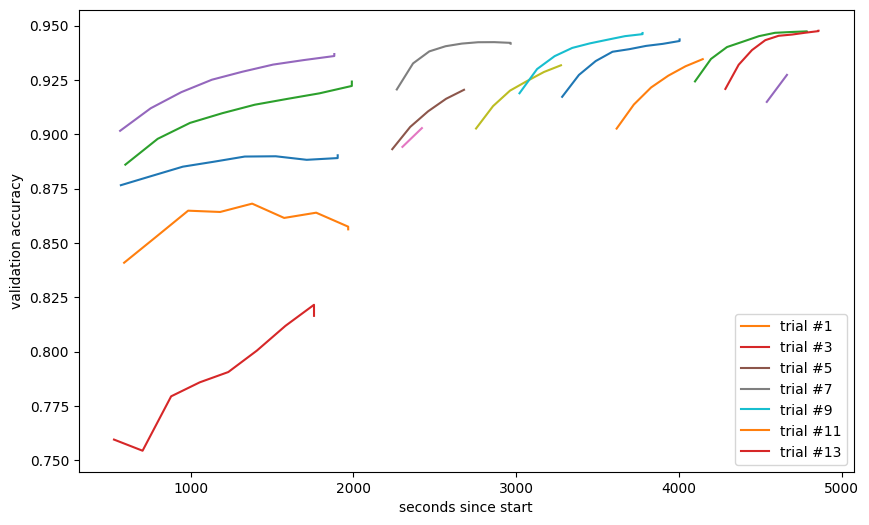

In [17]:
# wrap in try/except in case of flaky I/O issues
try:
    trials_df, curve_df = early_stopping_exp_to_df(experiment)
    plot_curves_by_wall_time(trials_df, curve_df)
except Exception as e:
    print(f"Encountered exception while plotting results: {e}")
